<img src="img/ENSAE_logo.jpg">

# *ELTDM Project*
# *Parallelised Community Detection with Spark MapReduce*  
**Mastère Spécialisé Data Science, 2018-19, "Éléments logiciels pour le traitement des données massives"** 
  
**Alban CHAMPEVILLE DE BOISJOLLY**   
**Yosuke IJIRI**  
  

In [51]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

## 0. Abstract

This project implements a parallelised community detection algorithm proposed by [*"S. Moon, et al., Parallel community detection on large graphs with MapReduce and GraphChi, Data Knowl. Eng. (2015)"*.](http://dx.doi.org/10.1016/j.datak.2015.05.001) The model is based on Girvan-Newman Algorithm. We use Python, Spark and AWS as the environment.

## 1. Introduction

Analysing network datum has become a key issue in many areas to base suggestions, advices and strategies in many sectors and applications. Community detection aims at identifying clusters in a network, i.e. regroup vertices into groups of high density connected vertices i.a. to make friends recommendations or target marketing. The Girvan-Newman algorithm is one of the most used for this objective. It uses the concept of edge betweenness, which is a measure of the centrality and influence of an edge in a network, with the shortest-path method.

Given the size of networks and the method used to compute the edge betweenness, parallelization of the computation is unavoidable to realize the task efficiently. Our work is focused on the Shortest-Path Betweeness MapReduce Algorithm (SPB-MRA). Parallelizing computations will be realized at each of the 4 stages of the Map-Reduce algorithm.

Related article:  " Parallel community detection on large graphs with MapReduce and GraphChi" published in 2015 by Seunghyeon Moon, Jae-Gil Lee, Minseo Kang, Minsoo Choy and Jin-woo Lee.

## 2. Model

Community Detection, Modularity Method

## 3. Algorithm

Girvan-Newman Algorithm

<img src="img/algo.png" width="400" align="left">

## 4. Data

Stanford Large Network Dataset Collection (https://snap.stanford.edu/data/)

## 5. Environment

Python + Spark on single laptop

Hardware Specification  
CPU: 2.6GHz dual core, Intel Core i5 processor  
Memory: 8GB 1600 MHz DDR3  
OS: macOS Mojave, Version 10.14.2  

## 6. Implementation

Here is the code:

In [25]:
import numpy as np
import pandas as pd

In [26]:
import os
os.getcwd()

'/Users/IjiriYosuke/Documents/GitHub/ELTDM-Project'

In [27]:
# Read the data
#data = np.loadtxt("./Data/test.txt", dtype='uint16')
#data = np.loadtxt("./Data/ca-GrQc_small.txt", dtype='uint16')
#data = np.loadtxt("./Data/email-Eu-core.txt", dtype='uint16')
#data = np.loadtxt("./Data/soc-ANU-residence_without_weights.txt", dtype='uint16')
#data = np.loadtxt("./Data/soc-physicians.txt", dtype='uint16')
data = np.loadtxt("./Data/soc-karate.txt", dtype='uint16')

#print(data)
print(type(data))
#data_ = pd.DataFrame(data)
#data_.to_csv("./Data/test_.txt", sep="/t", header=None, index=False)
#np.savetxt("./Data/test_.txt", data, fmt="%.0f", delimiter = "\t")

<class 'numpy.ndarray'>


In [29]:
#sc.stop()
from copy import deepcopy  # For making a deep copy of tuple
from itertools import groupby
from pyspark import SparkContext, SparkConf
conf = (SparkConf()
        .setMaster("local[2]")
        .setAppName("Test Name")
        .set('spark.executor.memory', '14g')
        .set('spark.driver.memory', '14g'))
sc = SparkContext(conf = conf)
#SparkConf().set('spark.driver.memory', '14g')
#SparkConf().set('spark.executor.memory', '14g')
#SparkConf().set('spark.app.name', 'test')
#sc = SparkContext(conf=SparkConf())
sc

<SparkContext master=local[2] appName=Test Name>

In [30]:
sc._conf.getAll()

[('spark.executor.memory', '14g'),
 ('spark.app.name', 'Test Name'),
 ('spark.app.id', 'local-1545434175699'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.driver.port', '53555'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.driver.memory', '14g'),
 ('spark.master', 'local[2]'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.driver.host', '172.20.10.2')]

In [31]:
d = sc.parallelize(data)
d = d.map(lambda x: x if x[0] < x[1] else [x[1], x[0]]).filter(lambda x: x[0] != x[1]).collect()  # remove edge between a sigle node and prepare to remove duplicate edges
d = set(map(tuple, d))  # Remove duplicate edges
d = list(d)
d = list(map(list, d))

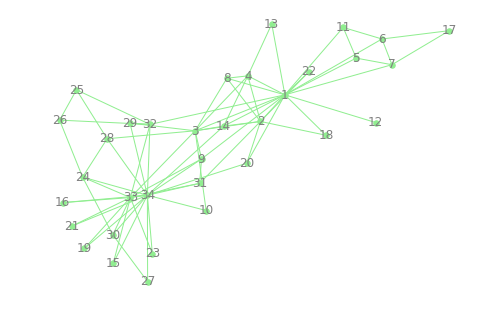

In [32]:
#Visualisation of the graph
import pandas
import networkx as nx
import matplotlib.pyplot as plt

nodes = set([n1 for n1, n2 in d] + [n2 for n1, n2 in d])  # We keep this original node list during the whole process
nsize=30
import time
def draw_graph(graph):
    # extract nodes from graph
    #nodes = set([n1 for n1, n2 in graph] + [n2 for n1, n2 in graph])
    # create networkx graph
    G=nx.Graph()
    # add nodes
    for node in nodes:
        G.add_node(node)
    # add edges
    for edge in graph:
        G.add_edge(edge[0], edge[1])
    # draw graph
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels = True, node_size=nsize, node_color='lightgreen', edge_color='lightgreen', font_color='gray')
    # show graph
    t = float(time.time())
    plt.savefig('./Data/Figures/Pre_Round1.png')
    plt.show()

G= draw_graph(data)

In [33]:
nodeId = np.unique(d)
nrow = len(d)
nb_edges_initial = nrow
print("The data contains")
print(len(nodeId), "distinct nodes, and", nrow, "distinct edges")

The data contains
34 distinct nodes, and 78 distinct edges


In [34]:
# Make a list of adjacency lists (first element is the node of origin)
adj_list = []
for n in nodeId:
    adj = []
    for i in range(nrow):
        if d[i][0] == n:
            adj.append(d[i][1])
        if d[i][1] == n:
            adj.append(d[i][0])
    adj = list(set(adj)) 
    adj.insert(0, n)
    adj_list.append(adj)
#print(adj_list)

In [35]:
# Make tuple for each node
class tuples():
    def __init__(self, targetId, sourceId, distance, status, weight, pathInfo, adjList) :
        self.targetId = targetId
        self.sourceId = sourceId
        self.distance = distance
        self.status = status
        self.weight = weight
        self.pathInfo = pathInfo
        self.adjList = adjList

network = []
for n in nodeId:
    v = tuples(targetId = n, sourceId = n, distance = 0, status = 'a', weight = 1, pathInfo = [], adjList = [])
    for i in range(len(adj_list)):
        if adj_list[i][0] == n:
            v.adjList = adj_list[i][1:len(adj_list[i])]
            break
    network.append([v.targetId, v.sourceId, v.distance, v.status, v.weight, v.pathInfo, v.adjList])
#for i in range(len(network)):
#    print(network[i])

### Main Parallelisation part

In [36]:
# Set a dataset and create key-value pairs
rdd = sc.parallelize(network)
rdd = rdd.map(lambda x: (x[0], x[1:]))
output = rdd.collect()

#### Stage 1 - Map 

This part employes Breadth First Search

In [37]:
def stage1_map(p):  
    result = []
    if p[1][2] == 'a':
        p[1][2] = 'i'
        p[1][1] += 1
        p[1][4].append(p[0])
        x = deepcopy(p)
        result.append(x)
        temp = p[1][5].copy()
        for i in range(len(temp)):
            k = temp[i]
            p[1][2] = 'a'
            p[1][5] = []
            y = deepcopy(p)
            result.append((k, y[1]))
        return result
    else:
        els = deepcopy(p)
        result.append(els)
        return result
'''
pos_map1 = rdd.flatMap(stage1_map)
pos_map1.collect()
'''

'\npos_map1 = rdd.flatMap(stage1_map)\npos_map1.collect()\n'

#### Stage 1 - Reduce 

This part consists of 6 steps:  
1) Add *sourceId* to key  
2) Aggregate the values that belong to the same key  
3) Take only values that have the shortest distance in the same key  
4) Replace *weight* of such values $\in minList$ with the size of $minList$  
5) Flatten values and list the tuples  
6) Fill in any empty adjList

In [38]:
#pos_map1.collect()
#pos_map1_test.collect()
'''
red1_twokeys = pos_map1.map(lambda x: ((x[0],x[1][0]), x[1][1:]))
'''
#red1_twokeys = pos_map1_test.map(lambda x: ((x[0],x[1][0]), x[1][1:]))
#red1_twokeys.collect()

'\nred1_twokeys = pos_map1.map(lambda x: ((x[0],x[1][0]), x[1][1:]))\n'

In [39]:
def join(x, y):
    # 4 conditional statements below to join values
    # with correct level of nesting
    if (type(x[0]) is list) and (type(y[0]) is not list):
        return x+[y]
    elif (type(x[0]) is not list) and (type(y[0]) is list):
        return [x]+y
    elif (type(x[0]) is not list) and (type(y[0]) is not list):
        return [x]+[y]
    else:
        return x+y
    isinstance(x[0], int)
'''
red1_grouped = red1_twokeys.reduceByKey(join)
#red1_twokeys.reduceByKey(join).collect()
'''

'\nred1_grouped = red1_twokeys.reduceByKey(join)\n#red1_twokeys.reduceByKey(join).collect()\n'

In [40]:
def stage1_reduce(x):
    if type(x[1][0]) is list:
        m = x[1][0][0]
        for s in range(len(x[1])):
            if x[1][s][0] < m:
                m = x[1][s][0]
        minList = []
        # Drop tuple(s) with non-shortest distance
        for s in range(len(x[1])):
            if x[1][s][0] == m:
                minList.append(x[1][s])
        y = (x[0], minList)
        # Update weight
        for s in range(len(minList)):
            y[1][s][2] = len(minList)
        return y
    else:
        return x
'''
red1_weighted = red1_grouped.map(stage1_reduce)
#red1_grouped.map(stage1_reduce).collect()
'''

'\nred1_weighted = red1_grouped.map(stage1_reduce)\n#red1_grouped.map(stage1_reduce).collect()\n'

In [41]:
def twokeys_to_onekey(x):
    k = x[0][0]
    v = [x[0][1]]
    v.extend(x[1])
    return k, v
'''
# From two-keys tuples to one-key tuples
record = red1_weighted.map(twokeys_to_onekey).collect()

# To flatten the grouped values (non-parallelized)
new = []
for i in range(len(record)):
    if type(record[i][1][1]) is list:
        record[i]
        key = record[i][0]
        srcId = [record[i][1][0]]
        others = record[i][1][1:]
        for j in range(len(others)):
            s = srcId.copy()
            o = others[j]
            s.extend(o)
            newrec = (key, s)
            new.append(newrec)
pos_red1 = list(filter(lambda item: type(item[1][1]) != list, record))  
pos_red1.extend(new)
for i in range(len(pos_red1)):
    print(pos_red1[i])
output = pos_red1.copy()
'''

'\n# From two-keys tuples to one-key tuples\nrecord = red1_weighted.map(twokeys_to_onekey).collect()\n\n# To flatten the grouped values (non-parallelized)\nnew = []\nfor i in range(len(record)):\n    if type(record[i][1][1]) is list:\n        record[i]\n        key = record[i][0]\n        srcId = [record[i][1][0]]\n        others = record[i][1][1:]\n        for j in range(len(others)):\n            s = srcId.copy()\n            o = others[j]\n            s.extend(o)\n            newrec = (key, s)\n            new.append(newrec)\npos_red1 = list(filter(lambda item: type(item[1][1]) != list, record))  \npos_red1.extend(new)\nfor i in range(len(pos_red1)):\n    print(pos_red1[i])\noutput = pos_red1.copy()\n'

#### Stage2 - Map & Reduce

In [42]:
from operator import add
def stage2_map(x):
    edges_on_the_path = []
    for i in range(len(x[1][4])-1):
        k = (x[1][4][i], x[1][4][i+1])
        w = x[1][3]
        edges_on_the_path.append((k, 1/w))
    return edges_on_the_path

#### Stage3 - Map & Reduce

#### Stage4 - Map

In [43]:
def stage4_map(x):
    counter = 0
    output = []
    for i in range(len(distributed_cache)):
        if x[0] in distributed_cache[i][0]:
            counter += 1  # Increase counter if its key is affected by the removal of the edge(s)
            c = distributed_cache[i][0][not(distributed_cache[i][0].index(x[0]))]  # Take the corresponding node
            try:
                x[1][5].remove(c)  # Remove if the corresponding node exists in the adjList
            except ValueError:
                pass  # Pass otherwise
    if counter == 0:
        return [tuple(x)]
    else:
        new = (x[1][0], [x[1][0], 0, 'a', 1, [], []])
        return x, new

#### Stage4 - Reduce

In [44]:
def stage4_reduce(x, y):
    if x[2] == 'a' and y[2] == 'a':
        return x
    elif x[2] == 'a' and y[2] == 'i':
        x[5] = y[5].copy()
        return x
    elif x[2] == 'i' and y[2] == 'a':
        y[5] = x[5].copy()
        return y
    else:
        return x+y
def revision(x):  # To flatten the pressed tuples (ones with status i)
    tup = []
    if len(x[1]) > 6:
        for i in range(int(len(x[1])/6)):
            tup.append((x[0],x[1][i*6:i*6+6]))
        return tup
    else:
        return [x]

In [45]:
def from_tuples_to_edgelist(x):
    res = []
    for i in range(len(x)):
        for j in range(len(x[i][1][5])):
            res.append([x[i][0], x[i][1][5][j]])
    res = set(map(tuple, res))  # Remove duplicate edges
    res = list(res)
    result = list(map(list, res))
    return result

In [46]:
#Visualisation of the graph
import pandas
import networkx as nx
import matplotlib.pyplot as plt
from datetime import datetime

nodes = set([n1 for n1, n2 in data] + [n2 for n1, n2 in data])
r=1
def draw_graph(graph, r):
    # extract nodes from graph
    #nodes = set([n1 for n1, n2 in graph] + [n2 for n1, n2 in graph])
    # create networkx graph
    G=nx.Graph()
    # add nodes
    for node in nodes:
        G.add_node(node)
    # add edges
    for edge in graph:
        G.add_edge(edge[0], edge[1])
    # draw graph
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels = True, node_size=nsize, node_color="lightgreen", edge_color='lightgreen', font_color='gray')
    # show graph
    t = float(time.time())
#    plt.savefig('./Data/figure_%f.png' %t)
    plt.savefig('./Data/Figures/Post_Round_%d.png' %r)
    plt.show()

### Modularity Q

$Q=\sum_{i}(e_{ii}-a_i^2) = \mathrm{Tr}\ {\bf e} - \|{\bf e}^2\|$

In [47]:
def Q_modularity(elist, nodes):

    c = sc.parallelize(elist)
    c = c.map(lambda x: x if x[0] < x[1] else [x[1], x[0]]).filter(lambda x: x[0] != x[1]).collect()  # remove edge between a sigle node and prepare to remove duplicate edges
    c = set(map(tuple, c))  # Remove duplicate edges
    c = list(c)
    c = list(map(list, c))
    nb_edges = len(c)###########
    #print(c)

    H=nx.Graph()
    # add nodes
    for node in nodes:
        H.add_node(node)
    # add edges
    for edge in c:
        H.add_edge(edge[0], edge[1])
    #draw_graph(c)

    com_dic = {}
    com_id = 0

    for n in nodes:
        try:
            com_dic[n]
        except KeyError:
            com_id += 1
            com_dic[n] = com_id
            for m in nodes:
                if (n != m) and (nx.has_path(H, m, n)):  # has_path(G, source, target)
                    try:
                        com_dic[m]
                    except KeyError:
                        com_dic[m] = com_id

    #print("\nCommunity Labelling is:", com_dic)

    com_ids = list(set(com_dic.values()))
    com_ids
    
    e = np.matrix([[0.]*len(com_ids)]*len(com_ids))
    
    for i in range(len(com_ids)):
        for j in range(len(com_ids)):
            keys_i = [k for k, v in com_dic.items() if v == i+1]
            keys_j = [k for k, v in com_dic.items() if v == j+1]
            if i == j:
                nb_within = 0
                for edge in c:
                    if set(edge) <= set(keys_i):
                        nb_within += 1
                e[i, i] = nb_within/nb_edges_initial
            elif i < j:
                nb_cross = 0
                for edge in d:
                    if (({edge[0]} <= set(keys_i)) and ({edge[1]} <= set(keys_j))) or (({edge[0]} <= set(keys_j)) and ({edge[1]} <= set(keys_i))):
                        nb_cross += 1
                e[i, j] = nb_cross/nb_edges_initial
                e[j, i] = nb_cross/nb_edges_initial       
    #print(e)
    a = np.ndarray.sum(e, axis=1)
    #b = np.power(e,2)
    
    a = np.squeeze(np.asarray(a))
    Q = float(e.trace()) - np.dot(a, a)
    #Q2 = float(e.trace()) - np.sum(b)
    #print("Q modularity is:", Q)
    return Q, com_dic

### Rounds Stage1-4

Data contains 34 nodes, and 78 edges (including duplicates) 

ROUND 1 STARTED! 

Iteration 1 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 seconds ( 0.0 mins ).
 Now iteration 1 finished!
Iteration 1 finished. There are 156 / 190 active tuples left. 

Iteration 2 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 seconds ( 0.0 mins ).
 Now iteration 2 finished!
Iteration 2 finished. There are 1056 / 1246 active tuples left. 

Iteration 3 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Red

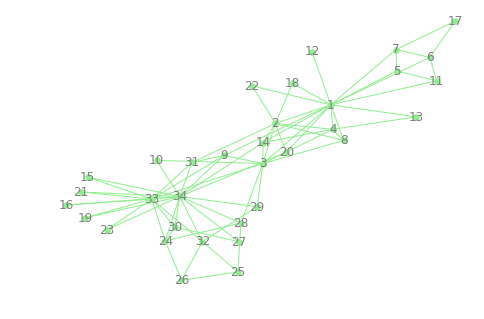

Community Labelling is: {1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 33: 1, 34: 1}
(There are 1 communities now)
Q Modularity is: 0.012656147271531859
Round 1 took 6.4 seconds ( 0.1 mins)

 

ROUND 2 STARTED! 

Iteration 1 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 seconds ( 0.0 mins ).
 Now iteration 1 finished!
Iteration 1 finished. There are 154 / 188 active tuples left. 

Iteration 2 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 s

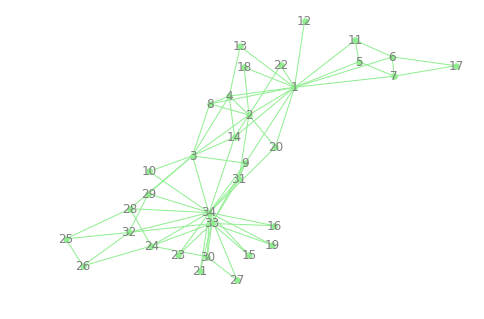

Community Labelling is: {1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 33: 1, 34: 1}
(There are 1 communities now)
Q Modularity is: 0.024983563445101886
Round 2 took 7.1 seconds ( 0.1 mins)

 

ROUND 3 STARTED! 

Iteration 1 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 seconds ( 0.0 mins ).
 Now iteration 1 finished!
Iteration 1 finished. There are 152 / 186 active tuples left. 

Iteration 2 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 s

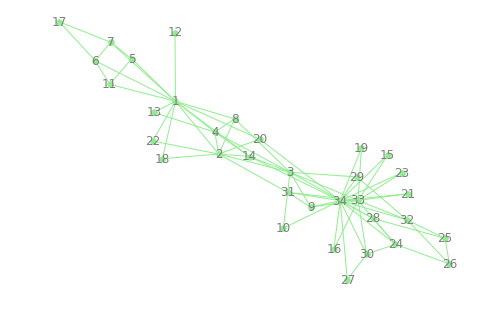

Community Labelling is: {1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 33: 1, 34: 1}
(There are 1 communities now)
Q Modularity is: 0.03698224852071008
Round 3 took 7.3 seconds ( 0.1 mins)

 

ROUND 4 STARTED! 

Iteration 1 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 seconds ( 0.0 mins ).
 Now iteration 1 finished!
Iteration 1 finished. There are 150 / 184 active tuples left. 

Iteration 2 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 se

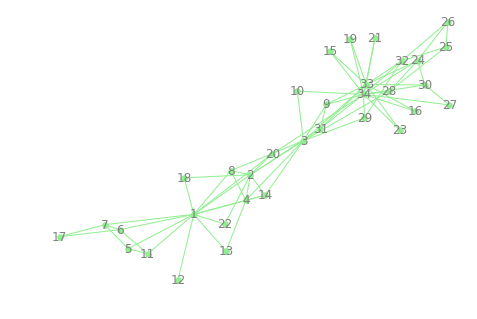

Community Labelling is: {1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 33: 1, 34: 1}
(There are 1 communities now)
Q Modularity is: 0.048652202498356334
Round 4 took 7.3 seconds ( 0.1 mins)

 

ROUND 5 STARTED! 

Iteration 1 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 seconds ( 0.0 mins ).
 Now iteration 1 finished!
Iteration 1 finished. There are 148 / 182 active tuples left. 

Iteration 2 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 s

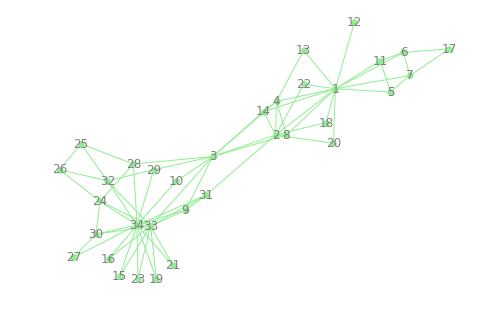

Community Labelling is: {1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 33: 1, 34: 1}
(There are 1 communities now)
Q Modularity is: 0.059993425378040754
Round 5 took 6.9 seconds ( 0.1 mins)

 

ROUND 6 STARTED! 

Iteration 1 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 seconds ( 0.0 mins ).
 Now iteration 1 finished!
Iteration 1 finished. There are 146 / 180 active tuples left. 

Iteration 2 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 s

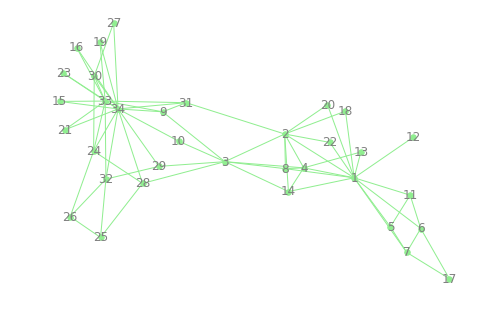

Community Labelling is: {1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 33: 1, 34: 1}
(There are 1 communities now)
Q Modularity is: 0.07100591715976323
Round 6 took 9.2 seconds ( 0.2 mins)

 

ROUND 7 STARTED! 

Iteration 1 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 seconds ( 0.0 mins ).
 Now iteration 1 finished!
Iteration 1 finished. There are 144 / 178 active tuples left. 

Iteration 2 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 se

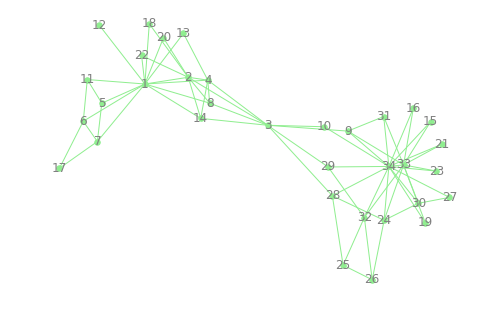

Community Labelling is: {1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 33: 1, 34: 1}
(There are 1 communities now)
Q Modularity is: 0.08168967784352399
Round 7 took 8.6 seconds ( 0.1 mins)

 

ROUND 8 STARTED! 

Iteration 1 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 seconds ( 0.0 mins ).
 Now iteration 1 finished!
Iteration 1 finished. There are 142 / 176 active tuples left. 

Iteration 2 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 se

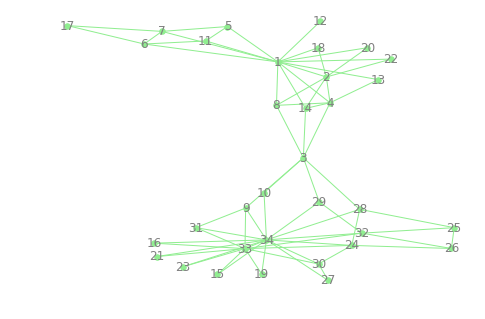

Community Labelling is: {1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 33: 1, 34: 1}
(There are 1 communities now)
Q Modularity is: 0.0920447074293228
Round 8 took 12.8 seconds ( 0.2 mins)

 

ROUND 9 STARTED! 

Iteration 1 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 seconds ( 0.0 mins ).
 Now iteration 1 finished!
Iteration 1 finished. There are 140 / 174 active tuples left. 

Iteration 2 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 se

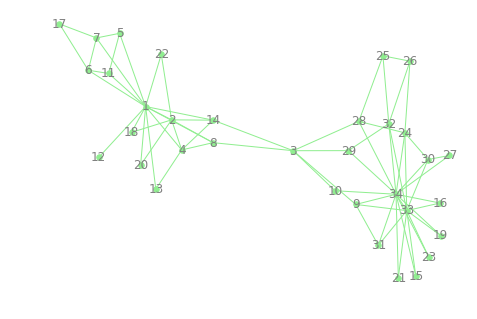

Community Labelling is: {1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 33: 1, 34: 1}
(There are 1 communities now)
Q Modularity is: 0.10207100591715978
Round 9 took 13.2 seconds ( 0.2 mins)

 

ROUND 10 STARTED! 

Iteration 1 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 seconds ( 0.0 mins ).
 Now iteration 1 finished!
Iteration 1 finished. There are 138 / 172 active tuples left. 

Iteration 2 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 

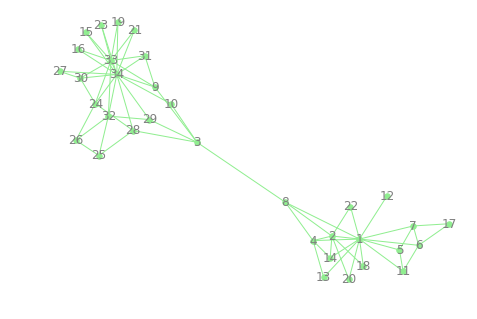

Community Labelling is: {1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 33: 1, 34: 1}
(There are 1 communities now)
Q Modularity is: 0.11176857330703482
Round 10 took 10.3 seconds ( 0.2 mins)

 

ROUND 11 STARTED! 

Iteration 1 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 seconds ( 0.0 mins ).
 Now iteration 1 finished!
Iteration 1 finished. There are 136 / 170 active tuples left. 

Iteration 2 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0

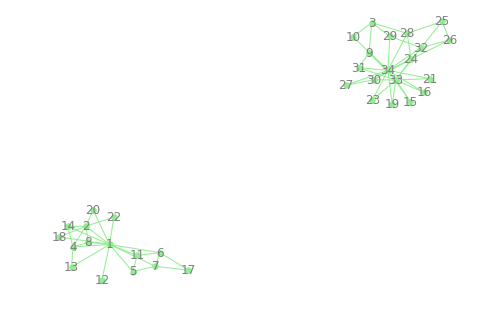

Community Labelling is: {1: 1, 2: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 11: 1, 12: 1, 13: 1, 14: 1, 17: 1, 18: 1, 20: 1, 22: 1, 3: 2, 9: 2, 10: 2, 15: 2, 16: 2, 19: 2, 21: 2, 23: 2, 24: 2, 25: 2, 26: 2, 27: 2, 28: 2, 29: 2, 30: 2, 31: 2, 32: 2, 33: 2, 34: 2}
(There are 2 communities now)
Q Modularity is: 0.22698882314266933
Round 11 took 7.0 seconds ( 0.1 mins)

 

ROUND 12 STARTED! 

Iteration 1 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 seconds ( 0.0 mins ).
 Now iteration 1 finished!
Iteration 1 finished. There are 134 / 168 active tuples left. 

Iteration 2 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 

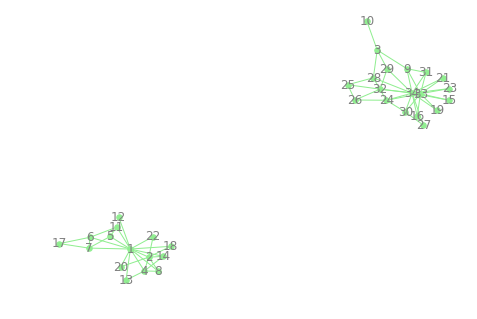

Community Labelling is: {1: 1, 2: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 11: 1, 12: 1, 13: 1, 14: 1, 17: 1, 18: 1, 20: 1, 22: 1, 3: 2, 9: 2, 10: 2, 15: 2, 16: 2, 19: 2, 21: 2, 23: 2, 24: 2, 25: 2, 26: 2, 27: 2, 28: 2, 29: 2, 30: 2, 31: 2, 32: 2, 33: 2, 34: 2}
(There are 2 communities now)
Q Modularity is: 0.23011176857330695
Round 12 took 2.2 seconds ( 0.0 mins)

 

ROUND 13 STARTED! 

Iteration 1 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 seconds ( 0.0 mins ).
 Now iteration 1 finished!
Iteration 1 finished. There are 76 / 382 active tuples left. 

Iteration 2 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 s

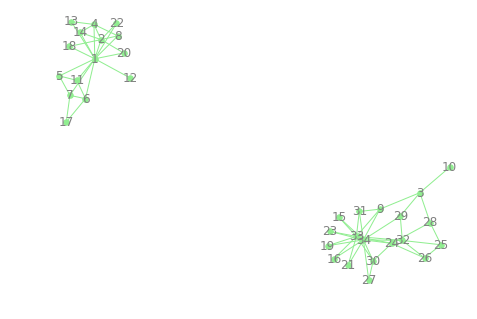

Community Labelling is: {1: 1, 2: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 11: 1, 12: 1, 13: 1, 14: 1, 17: 1, 18: 1, 20: 1, 22: 1, 3: 2, 9: 2, 10: 2, 15: 2, 16: 2, 19: 2, 21: 2, 23: 2, 24: 2, 25: 2, 26: 2, 27: 2, 28: 2, 29: 2, 30: 2, 31: 2, 32: 2, 33: 2, 34: 2}
(There are 2 communities now)
Q Modularity is: 0.23290598290598286
Round 13 took 1.8 seconds ( 0.0 mins)

 

ROUND 14 STARTED! 

Iteration 1 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 seconds ( 0.0 mins ).
 Now iteration 1 finished!
Iteration 1 finished. There are 74 / 380 active tuples left. 

Iteration 2 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 s

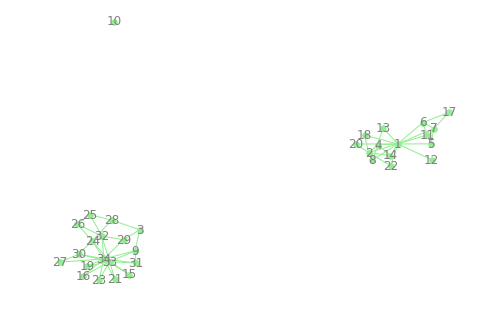

Community Labelling is: {1: 1, 2: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 11: 1, 12: 1, 13: 1, 14: 1, 17: 1, 18: 1, 20: 1, 22: 1, 3: 2, 9: 2, 15: 2, 16: 2, 19: 2, 21: 2, 23: 2, 24: 2, 25: 2, 26: 2, 27: 2, 28: 2, 29: 2, 30: 2, 31: 2, 32: 2, 33: 2, 34: 2, 10: 3}
(There are 3 communities now)
Q Modularity is: 0.20381328073635752
Round 14 took 1.6 seconds ( 0.0 mins)

 

ROUND 15 STARTED! 

Iteration 1 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 seconds ( 0.0 mins ).
 Now iteration 1 finished!
Iteration 1 finished. There are 72 / 378 active tuples left. 

Iteration 2 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 s

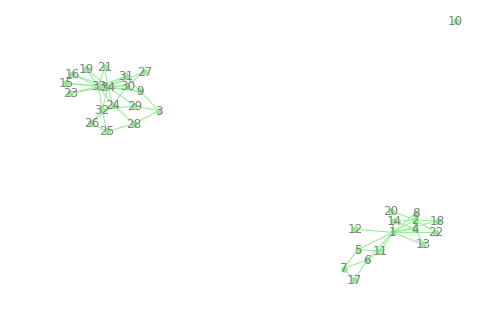

Community Labelling is: {1: 1, 2: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 11: 1, 12: 1, 13: 1, 14: 1, 17: 1, 18: 1, 20: 1, 22: 1, 3: 2, 9: 2, 15: 2, 16: 2, 19: 2, 21: 2, 23: 2, 24: 2, 25: 2, 26: 2, 27: 2, 28: 2, 29: 2, 30: 2, 31: 2, 32: 2, 33: 2, 34: 2, 10: 3}
(There are 3 communities now)
Q Modularity is: 0.20332018408941477
Round 15 took 2.0 seconds ( 0.0 mins)

 

ROUND 16 STARTED! 

Iteration 1 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 seconds ( 0.0 mins ).
 Now iteration 1 finished!
Iteration 1 finished. There are 54 / 616 active tuples left. 

Iteration 2 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 s

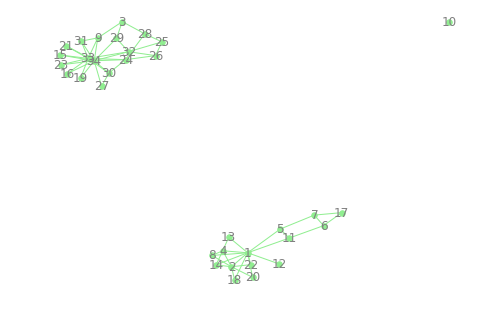

Community Labelling is: {1: 1, 2: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 11: 1, 12: 1, 13: 1, 14: 1, 17: 1, 18: 1, 20: 1, 22: 1, 3: 2, 9: 2, 15: 2, 16: 2, 19: 2, 21: 2, 23: 2, 24: 2, 25: 2, 26: 2, 27: 2, 28: 2, 29: 2, 30: 2, 31: 2, 32: 2, 33: 2, 34: 2, 10: 3}
(There are 3 communities now)
Q Modularity is: 0.2024983563445102
Round 16 took 1.4 seconds ( 0.0 mins)

 

ROUND 17 STARTED! 

Iteration 1 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 seconds ( 0.0 mins ).
 Now iteration 1 finished!
Iteration 1 finished. There are 52 / 614 active tuples left. 

Iteration 2 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 se

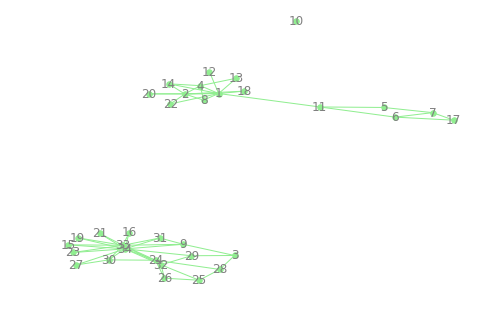

Community Labelling is: {1: 1, 2: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 11: 1, 12: 1, 13: 1, 14: 1, 17: 1, 18: 1, 20: 1, 22: 1, 3: 2, 9: 2, 15: 2, 16: 2, 19: 2, 21: 2, 23: 2, 24: 2, 25: 2, 26: 2, 27: 2, 28: 2, 29: 2, 30: 2, 31: 2, 32: 2, 33: 2, 34: 2, 10: 3}
(There are 3 communities now)
Q Modularity is: 0.20134779750164367
Round 17 took 2.2 seconds ( 0.0 mins)

 

ROUND 18 STARTED! 

Iteration 1 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 seconds ( 0.0 mins ).
 Now iteration 1 finished!
Iteration 1 finished. There are 50 / 612 active tuples left. 

Iteration 2 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 s

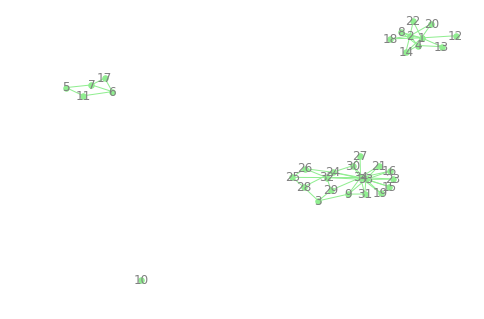

Community Labelling is: {1: 1, 2: 1, 4: 1, 8: 1, 12: 1, 13: 1, 14: 1, 18: 1, 20: 1, 22: 1, 3: 2, 9: 2, 15: 2, 16: 2, 19: 2, 21: 2, 23: 2, 24: 2, 25: 2, 26: 2, 27: 2, 28: 2, 29: 2, 30: 2, 31: 2, 32: 2, 33: 2, 34: 2, 5: 3, 6: 3, 7: 3, 11: 3, 17: 3, 10: 4}
(There are 4 communities now)
Q Modularity is: 0.20512820512820495
Round 18 took 2.4 seconds ( 0.0 mins)

 

ROUND 19 STARTED! 

Iteration 1 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 seconds ( 0.0 mins ).
 Now iteration 1 finished!
Iteration 1 finished. There are 48 / 610 active tuples left. 

Iteration 2 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 s

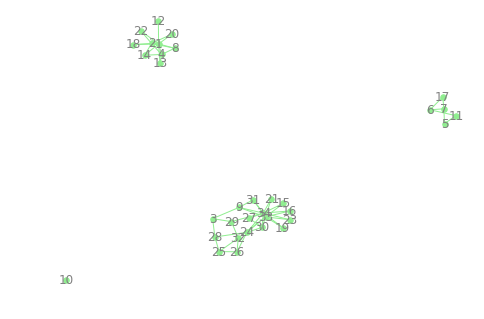

Community Labelling is: {1: 1, 2: 1, 4: 1, 8: 1, 12: 1, 13: 1, 14: 1, 18: 1, 20: 1, 22: 1, 3: 2, 9: 2, 15: 2, 16: 2, 19: 2, 21: 2, 23: 2, 24: 2, 25: 2, 26: 2, 27: 2, 28: 2, 29: 2, 30: 2, 31: 2, 32: 2, 33: 2, 34: 2, 5: 3, 6: 3, 7: 3, 11: 3, 17: 3, 10: 4}
(There are 4 communities now)
Q Modularity is: 0.20792241946088097
Round 19 took 2.0 seconds ( 0.0 mins)

 

ROUND 20 STARTED! 

Iteration 1 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 seconds ( 0.0 mins ).
 Now iteration 1 finished!
Iteration 1 finished. There are 70 / 252 active tuples left. 

Iteration 2 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 s

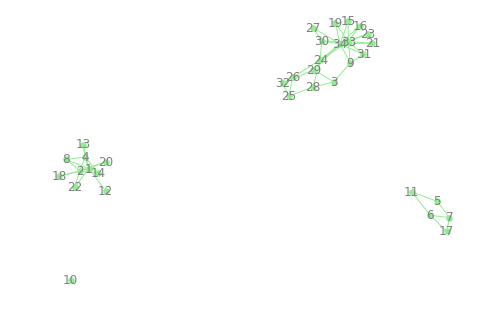

Community Labelling is: {1: 1, 2: 1, 4: 1, 8: 1, 12: 1, 13: 1, 14: 1, 18: 1, 20: 1, 22: 1, 3: 2, 9: 2, 15: 2, 16: 2, 19: 2, 21: 2, 23: 2, 24: 2, 25: 2, 26: 2, 27: 2, 28: 2, 29: 2, 30: 2, 31: 2, 32: 2, 33: 2, 34: 2, 5: 3, 6: 3, 7: 3, 11: 3, 17: 3, 10: 4}
(There are 4 communities now)
Q Modularity is: 0.21038790269559493
Round 20 took 1.7 seconds ( 0.0 mins)

 

ROUND 21 STARTED! 

Iteration 1 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 seconds ( 0.0 mins ).
 Now iteration 1 finished!
Iteration 1 finished. There are 68 / 250 active tuples left. 

Iteration 2 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 s

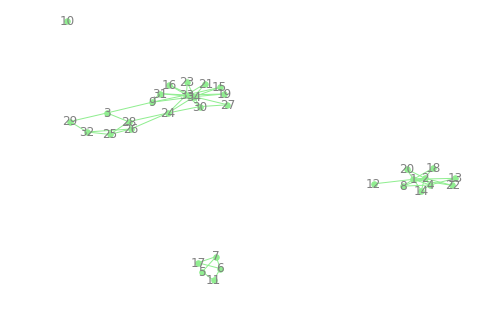

Community Labelling is: {1: 1, 2: 1, 4: 1, 8: 1, 12: 1, 13: 1, 14: 1, 18: 1, 20: 1, 22: 1, 3: 2, 9: 2, 15: 2, 16: 2, 19: 2, 21: 2, 23: 2, 24: 2, 25: 2, 26: 2, 27: 2, 28: 2, 29: 2, 30: 2, 31: 2, 32: 2, 33: 2, 34: 2, 5: 3, 6: 3, 7: 3, 11: 3, 17: 3, 10: 4}
(There are 4 communities now)
Q Modularity is: 0.21252465483234706
Round 21 took 2.0 seconds ( 0.0 mins)

 

ROUND 22 STARTED! 

Iteration 1 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 seconds ( 0.0 mins ).
 Now iteration 1 finished!
Iteration 1 finished. There are 66 / 248 active tuples left. 

Iteration 2 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 s

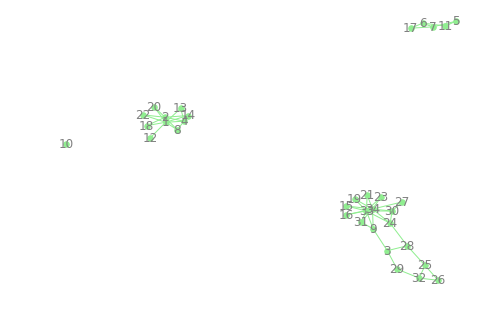

Community Labelling is: {1: 1, 2: 1, 4: 1, 8: 1, 12: 1, 13: 1, 14: 1, 18: 1, 20: 1, 22: 1, 3: 2, 9: 2, 15: 2, 16: 2, 19: 2, 21: 2, 23: 2, 24: 2, 25: 2, 26: 2, 27: 2, 28: 2, 29: 2, 30: 2, 31: 2, 32: 2, 33: 2, 34: 2, 5: 3, 6: 3, 7: 3, 11: 3, 17: 3, 10: 4}
(There are 4 communities now)
Q Modularity is: 0.21433267587113725
Round 22 took 1.8 seconds ( 0.0 mins)

 

ROUND 23 STARTED! 

Iteration 1 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 seconds ( 0.0 mins ).
 Now iteration 1 finished!
Iteration 1 finished. There are 64 / 246 active tuples left. 

Iteration 2 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 s

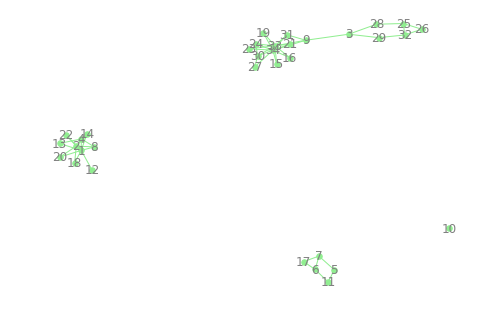

Community Labelling is: {1: 1, 2: 1, 4: 1, 8: 1, 12: 1, 13: 1, 14: 1, 18: 1, 20: 1, 22: 1, 3: 2, 9: 2, 15: 2, 16: 2, 19: 2, 21: 2, 23: 2, 24: 2, 25: 2, 26: 2, 27: 2, 28: 2, 29: 2, 30: 2, 31: 2, 32: 2, 33: 2, 34: 2, 5: 3, 6: 3, 7: 3, 11: 3, 17: 3, 10: 4}
(There are 4 communities now)
Q Modularity is: 0.21581196581196588
Round 23 took 2.1 seconds ( 0.0 mins)

 

ROUND 24 STARTED! 

Iteration 1 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 seconds ( 0.0 mins ).
 Now iteration 1 finished!
Iteration 1 finished. There are 62 / 244 active tuples left. 

Iteration 2 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 s

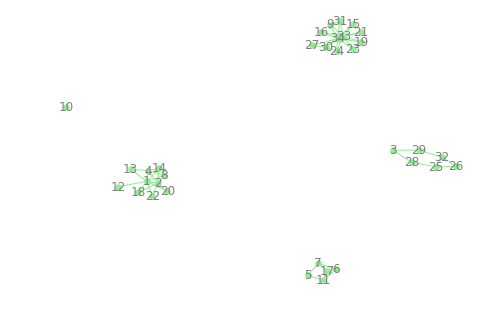

Community Labelling is: {1: 1, 2: 1, 4: 1, 8: 1, 12: 1, 13: 1, 14: 1, 18: 1, 20: 1, 22: 1, 3: 2, 25: 2, 26: 2, 28: 2, 29: 2, 32: 2, 5: 3, 6: 3, 7: 3, 11: 3, 17: 3, 9: 4, 15: 4, 16: 4, 19: 4, 21: 4, 23: 4, 24: 4, 27: 4, 30: 4, 31: 4, 33: 4, 34: 4, 10: 5}
(There are 5 communities now)
Q Modularity is: 0.21433267587113736
Round 24 took 1.9 seconds ( 0.0 mins)

 

ROUND 25 STARTED! 

Iteration 1 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 seconds ( 0.0 mins ).
 Now iteration 1 finished!
Iteration 1 finished. There are 60 / 242 active tuples left. 

Iteration 2 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 s

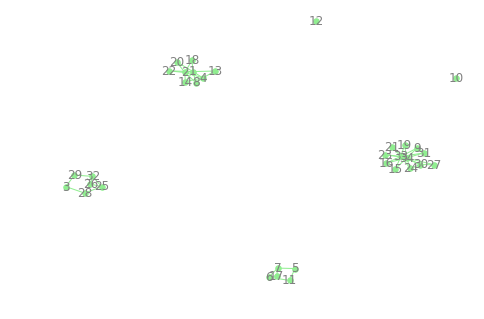

Community Labelling is: {1: 1, 2: 1, 4: 1, 8: 1, 13: 1, 14: 1, 18: 1, 20: 1, 22: 1, 3: 2, 25: 2, 26: 2, 28: 2, 29: 2, 32: 2, 5: 3, 6: 3, 7: 3, 11: 3, 17: 3, 9: 4, 15: 4, 16: 4, 19: 4, 21: 4, 23: 4, 24: 4, 27: 4, 30: 4, 31: 4, 33: 4, 34: 4, 10: 5, 12: 6}
(There are 6 communities now)
Q Modularity is: 0.20134779750164367
Round 25 took 1.4 seconds ( 0.0 mins)

 

ROUND 26 STARTED! 

Iteration 1 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 seconds ( 0.0 mins ).
 Now iteration 1 finished!
Iteration 1 finished. There are 34 / 328 active tuples left. 

Iteration 2 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 s

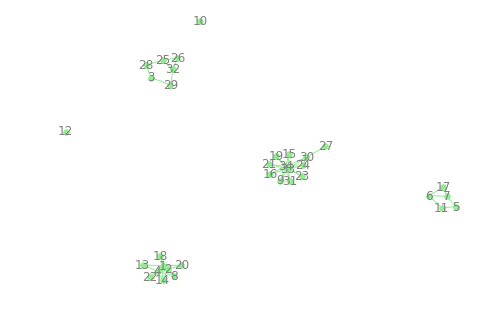

Community Labelling is: {1: 1, 2: 1, 4: 1, 8: 1, 13: 1, 14: 1, 18: 1, 20: 1, 22: 1, 3: 2, 25: 2, 26: 2, 28: 2, 29: 2, 32: 2, 5: 3, 6: 3, 7: 3, 11: 3, 17: 3, 9: 4, 15: 4, 16: 4, 19: 4, 21: 4, 23: 4, 24: 4, 27: 4, 30: 4, 31: 4, 33: 4, 34: 4, 10: 5, 12: 6}
(There are 6 communities now)
Q Modularity is: 0.2001972386587772
Round 26 took 1.4 seconds ( 0.0 mins)

 

ROUND 27 STARTED! 

Iteration 1 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 seconds ( 0.0 mins ).
 Now iteration 1 finished!
Iteration 1 finished. There are 44 / 240 active tuples left. 

Iteration 2 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 se

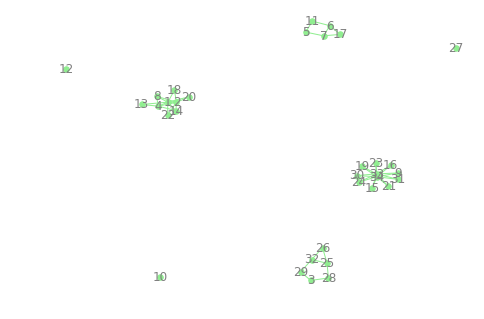

Community Labelling is: {1: 1, 2: 1, 4: 1, 8: 1, 13: 1, 14: 1, 18: 1, 20: 1, 22: 1, 3: 2, 25: 2, 26: 2, 28: 2, 29: 2, 32: 2, 5: 3, 6: 3, 7: 3, 11: 3, 17: 3, 9: 4, 15: 4, 16: 4, 19: 4, 21: 4, 23: 4, 24: 4, 30: 4, 31: 4, 33: 4, 34: 4, 10: 5, 12: 6, 27: 7}
(There are 7 communities now)
Q Modularity is: 0.17504930966469429
Round 27 took 1.4 seconds ( 0.0 mins)

 

ROUND 28 STARTED! 

Iteration 1 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 seconds ( 0.0 mins ).
 Now iteration 1 finished!
Iteration 1 finished. There are 42 / 238 active tuples left. 

Iteration 2 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 s

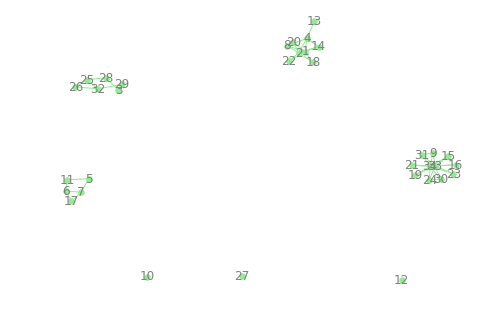

Community Labelling is: {1: 1, 2: 1, 4: 1, 8: 1, 13: 1, 14: 1, 18: 1, 20: 1, 22: 1, 3: 2, 25: 2, 26: 2, 28: 2, 29: 2, 32: 2, 5: 3, 6: 3, 7: 3, 11: 3, 17: 3, 9: 4, 15: 4, 16: 4, 19: 4, 21: 4, 23: 4, 24: 4, 30: 4, 31: 4, 33: 4, 34: 4, 10: 5, 12: 6, 27: 7}
(There are 7 communities now)
Q Modularity is: 0.1725838264299802
Round 28 took 1.3 seconds ( 0.0 mins)

 

ROUND 29 STARTED! 

Iteration 1 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 seconds ( 0.0 mins ).
 Now iteration 1 finished!
Iteration 1 finished. There are 32 / 300 active tuples left. 

Iteration 2 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 se

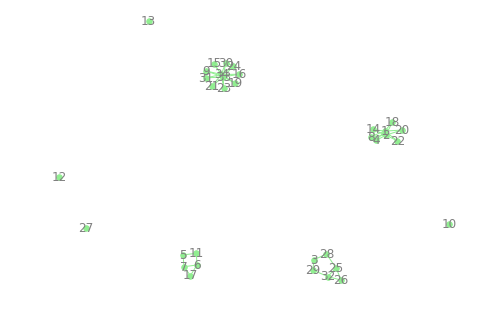

Community Labelling is: {1: 1, 2: 1, 4: 1, 8: 1, 14: 1, 18: 1, 20: 1, 22: 1, 3: 2, 25: 2, 26: 2, 28: 2, 29: 2, 32: 2, 5: 3, 6: 3, 7: 3, 11: 3, 17: 3, 9: 4, 15: 4, 16: 4, 19: 4, 21: 4, 23: 4, 24: 4, 30: 4, 31: 4, 33: 4, 34: 4, 10: 5, 12: 6, 13: 7, 27: 8}
(There are 8 communities now)
Q Modularity is: 0.1487508218277449
Round 29 took 1.3 seconds ( 0.0 mins)

 

ROUND 30 STARTED! 

Iteration 1 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 seconds ( 0.0 mins ).
 Now iteration 1 finished!
Iteration 1 finished. There are 30 / 298 active tuples left. 

Iteration 2 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 se

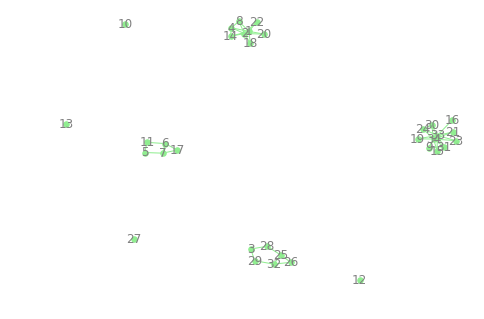

Community Labelling is: {1: 1, 2: 1, 4: 1, 8: 1, 14: 1, 18: 1, 20: 1, 22: 1, 3: 2, 25: 2, 26: 2, 28: 2, 29: 2, 32: 2, 5: 3, 6: 3, 7: 3, 11: 3, 17: 3, 9: 4, 15: 4, 16: 4, 19: 4, 21: 4, 23: 4, 24: 4, 30: 4, 31: 4, 33: 4, 34: 4, 10: 5, 12: 6, 13: 7, 27: 8}
(There are 8 communities now)
Q Modularity is: 0.1476002629848785
Round 30 took 1.3 seconds ( 0.0 mins)

 

ROUND 31 STARTED! 

Iteration 1 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 seconds ( 0.0 mins ).
 Now iteration 1 finished!
Iteration 1 finished. There are 40 / 214 active tuples left. 

Iteration 2 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 se

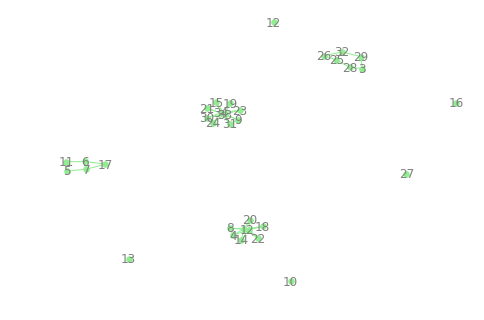

Community Labelling is: {1: 1, 2: 1, 4: 1, 8: 1, 14: 1, 18: 1, 20: 1, 22: 1, 3: 2, 25: 2, 26: 2, 28: 2, 29: 2, 32: 2, 5: 3, 6: 3, 7: 3, 11: 3, 17: 3, 9: 4, 15: 4, 19: 4, 21: 4, 23: 4, 24: 4, 30: 4, 31: 4, 33: 4, 34: 4, 10: 5, 12: 6, 13: 7, 16: 8, 27: 9}
(There are 9 communities now)
Q Modularity is: 0.12245233399079553
Round 31 took 1.7 seconds ( 0.0 mins)

 

ROUND 32 STARTED! 

Iteration 1 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 seconds ( 0.0 mins ).
 Now iteration 1 finished!
Iteration 1 finished. There are 38 / 212 active tuples left. 

Iteration 2 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 s

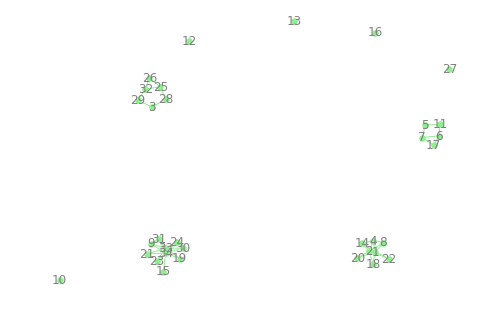

Community Labelling is: {1: 1, 2: 1, 4: 1, 8: 1, 14: 1, 18: 1, 20: 1, 22: 1, 3: 2, 25: 2, 26: 2, 28: 2, 29: 2, 32: 2, 5: 3, 6: 3, 7: 3, 11: 3, 17: 3, 9: 4, 15: 4, 19: 4, 21: 4, 23: 4, 24: 4, 30: 4, 31: 4, 33: 4, 34: 4, 10: 5, 12: 6, 13: 7, 16: 8, 27: 9}
(There are 9 communities now)
Q Modularity is: 0.121301775147929
Round 32 took 2.0 seconds ( 0.0 mins)

 

ROUND 33 STARTED! 

Iteration 1 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 seconds ( 0.0 mins ).
 Now iteration 1 finished!
Iteration 1 finished. There are 36 / 210 active tuples left. 

Iteration 2 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 sec

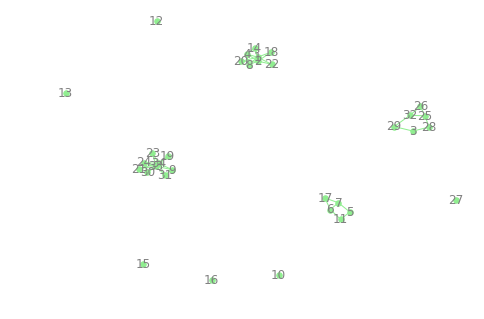

Community Labelling is: {1: 1, 2: 1, 4: 1, 8: 1, 14: 1, 18: 1, 20: 1, 22: 1, 3: 2, 25: 2, 26: 2, 28: 2, 29: 2, 32: 2, 5: 3, 6: 3, 7: 3, 11: 3, 17: 3, 9: 4, 19: 4, 21: 4, 23: 4, 24: 4, 30: 4, 31: 4, 33: 4, 34: 4, 10: 5, 12: 6, 13: 7, 15: 8, 16: 9, 27: 10}
(There are 10 communities now)
Q Modularity is: 0.09615384615384615
Round 33 took 1.3 seconds ( 0.0 mins)

 

ROUND 34 STARTED! 

Iteration 1 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 seconds ( 0.0 mins ).
 Now iteration 1 finished!
Iteration 1 finished. There are 34 / 208 active tuples left. 

Iteration 2 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0

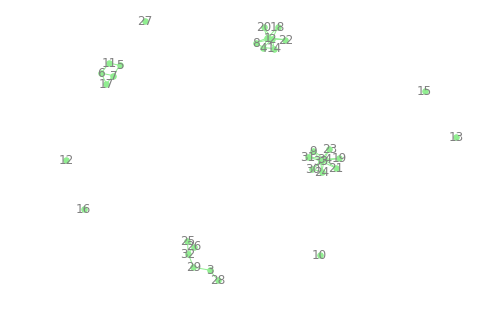

Community Labelling is: {1: 1, 2: 1, 4: 1, 8: 1, 14: 1, 18: 1, 20: 1, 22: 1, 3: 2, 25: 2, 26: 2, 28: 2, 29: 2, 32: 2, 5: 3, 6: 3, 7: 3, 11: 3, 17: 3, 9: 4, 19: 4, 21: 4, 23: 4, 24: 4, 30: 4, 31: 4, 33: 4, 34: 4, 10: 5, 12: 6, 13: 7, 15: 8, 16: 9, 27: 10}
(There are 10 communities now)
Q Modularity is: 0.09040105193951353
Round 34 took 1.3 seconds ( 0.0 mins)

 

ROUND 35 STARTED! 

Iteration 1 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 seconds ( 0.0 mins ).
 Now iteration 1 finished!
Iteration 1 finished. There are 12 / 264 active tuples left. 

Iteration 2 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0

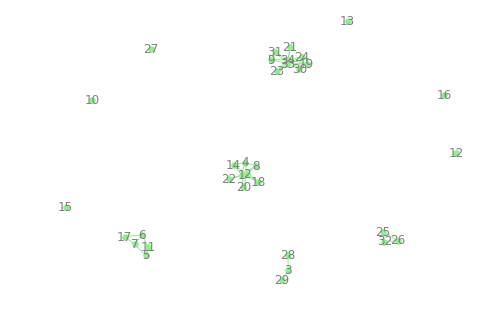

Community Labelling is: {1: 1, 2: 1, 4: 1, 8: 1, 14: 1, 18: 1, 20: 1, 22: 1, 3: 2, 28: 2, 29: 2, 5: 3, 6: 3, 7: 3, 11: 3, 17: 3, 9: 4, 19: 4, 21: 4, 23: 4, 24: 4, 30: 4, 31: 4, 33: 4, 34: 4, 10: 5, 12: 6, 13: 7, 15: 8, 16: 9, 25: 10, 26: 10, 32: 10, 27: 11}
(There are 11 communities now)
Q Modularity is: 0.09976988823142674
Round 35 took 1.8 seconds ( 0.0 mins)

 

ROUND 36 STARTED! 

Iteration 1 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 seconds ( 0.0 mins ).
 Now iteration 1 finished!
Iteration 1 finished. There are 10 / 262 active tuples left. 

Iteration 2 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 

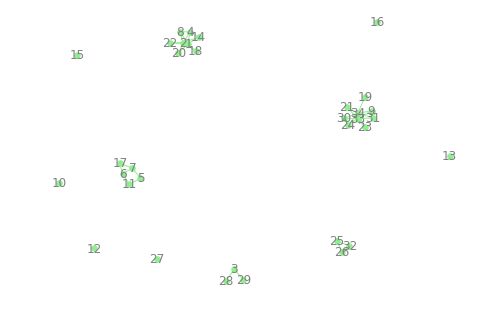

Community Labelling is: {1: 1, 2: 1, 4: 1, 8: 1, 14: 1, 18: 1, 20: 1, 22: 1, 3: 2, 28: 2, 29: 2, 5: 3, 6: 3, 7: 3, 11: 3, 17: 3, 9: 4, 19: 4, 21: 4, 23: 4, 24: 4, 30: 4, 31: 4, 33: 4, 34: 4, 10: 5, 12: 6, 13: 7, 15: 8, 16: 9, 25: 10, 26: 10, 32: 10, 27: 11}
(There are 11 communities now)
Q Modularity is: 0.09861932938856033
Round 36 took 1.3 seconds ( 0.0 mins)

 

ROUND 37 STARTED! 

Iteration 1 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 seconds ( 0.0 mins ).
 Now iteration 1 finished!
Iteration 1 finished. There are 32 / 186 active tuples left. 

Iteration 2 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 

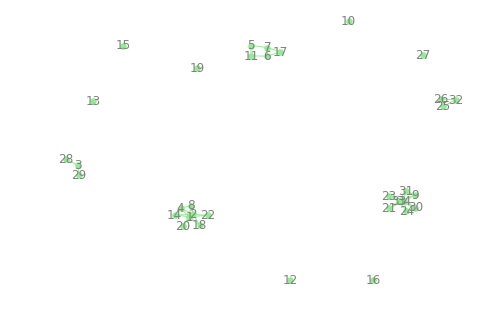

Community Labelling is: {1: 1, 2: 1, 4: 1, 8: 1, 14: 1, 18: 1, 20: 1, 22: 1, 3: 2, 28: 2, 29: 2, 5: 3, 6: 3, 7: 3, 11: 3, 17: 3, 9: 4, 21: 4, 23: 4, 24: 4, 30: 4, 31: 4, 33: 4, 34: 4, 10: 5, 12: 6, 13: 7, 15: 8, 16: 9, 19: 10, 25: 11, 26: 11, 32: 11, 27: 12}
(There are 12 communities now)
Q Modularity is: 0.07347140039447747
Round 37 took 1.4 seconds ( 0.0 mins)

 

ROUND 38 STARTED! 

Iteration 1 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 seconds ( 0.0 mins ).
 Now iteration 1 finished!
Iteration 1 finished. There are 30 / 184 active tuples left. 

Iteration 2 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took

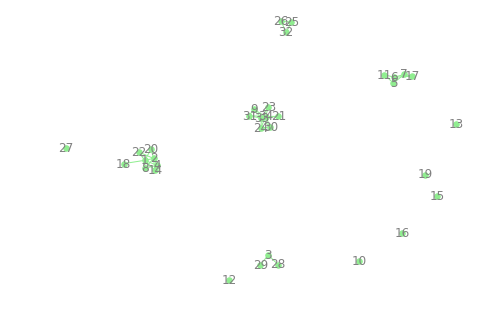

Community Labelling is: {1: 1, 2: 1, 4: 1, 8: 1, 14: 1, 18: 1, 20: 1, 22: 1, 3: 2, 28: 2, 29: 2, 5: 3, 6: 3, 7: 3, 11: 3, 17: 3, 9: 4, 21: 4, 23: 4, 24: 4, 30: 4, 31: 4, 33: 4, 34: 4, 10: 5, 12: 6, 13: 7, 15: 8, 16: 9, 19: 10, 25: 11, 26: 11, 32: 11, 27: 12}
(There are 12 communities now)
Q Modularity is: 0.07100591715976345
Round 38 took 1.1 seconds ( 0.0 mins)

 

ROUND 39 STARTED! 

Iteration 1 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 seconds ( 0.0 mins ).
 Now iteration 1 finished!
Iteration 1 finished. There are 28 / 180 active tuples left. 

Iteration 2 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took

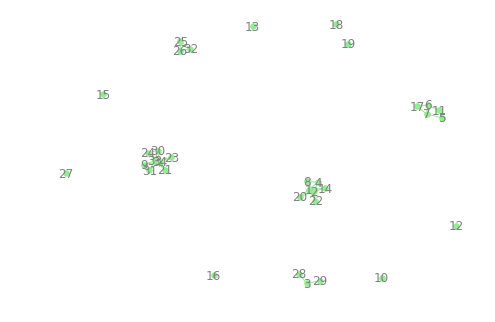

Community Labelling is: {1: 1, 2: 1, 4: 1, 8: 1, 14: 1, 20: 1, 22: 1, 3: 2, 28: 2, 29: 2, 5: 3, 6: 3, 7: 3, 11: 3, 17: 3, 9: 4, 21: 4, 23: 4, 24: 4, 30: 4, 31: 4, 33: 4, 34: 4, 10: 5, 12: 6, 13: 7, 15: 8, 16: 9, 18: 10, 19: 11, 25: 12, 26: 12, 32: 12, 27: 13}
(There are 13 communities now)
Q Modularity is: 0.04717291255752798
Round 39 took 1.0 seconds ( 0.0 mins)

 

ROUND 40 STARTED! 

Iteration 1 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 seconds ( 0.0 mins ).
 Now iteration 1 finished!
Iteration 1 finished. There are 26 / 178 active tuples left. 

Iteration 2 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList too

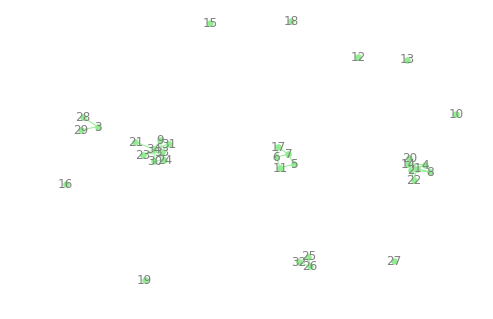

Community Labelling is: {1: 1, 2: 1, 4: 1, 8: 1, 14: 1, 20: 1, 22: 1, 3: 2, 28: 2, 29: 2, 5: 3, 6: 3, 7: 3, 11: 3, 17: 3, 9: 4, 21: 4, 23: 4, 24: 4, 30: 4, 31: 4, 33: 4, 34: 4, 10: 5, 12: 6, 13: 7, 15: 8, 16: 9, 18: 10, 19: 11, 25: 12, 26: 12, 32: 12, 27: 13}
(There are 13 communities now)
Q Modularity is: 0.046022353714661346
Round 40 took 0.9 seconds ( 0.0 mins)

 

ROUND 41 STARTED! 

Iteration 1 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 seconds ( 0.0 mins ).
 Now iteration 1 finished!
Iteration 1 finished. There are 28 / 158 active tuples left. 

Iteration 2 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList to

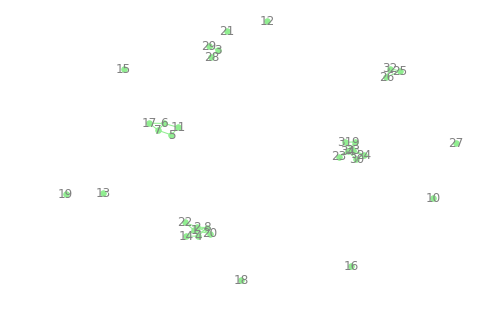

Community Labelling is: {1: 1, 2: 1, 4: 1, 8: 1, 14: 1, 20: 1, 22: 1, 3: 2, 28: 2, 29: 2, 5: 3, 6: 3, 7: 3, 11: 3, 17: 3, 9: 4, 23: 4, 24: 4, 30: 4, 31: 4, 33: 4, 34: 4, 10: 5, 12: 6, 13: 7, 15: 8, 16: 9, 18: 10, 19: 11, 21: 12, 25: 13, 26: 13, 32: 13, 27: 14}
(There are 14 communities now)
Q Modularity is: 0.0208744247205786
Round 41 took 1.0 seconds ( 0.0 mins)

 

ROUND 42 STARTED! 

Iteration 1 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 seconds ( 0.0 mins ).
 Now iteration 1 finished!
Iteration 1 finished. There are 26 / 156 active tuples left. 

Iteration 2 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList too

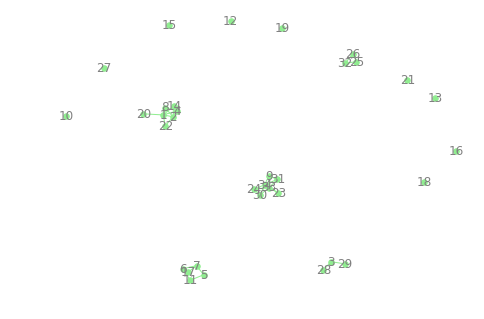

Community Labelling is: {1: 1, 2: 1, 4: 1, 8: 1, 14: 1, 20: 1, 22: 1, 3: 2, 28: 2, 29: 2, 5: 3, 6: 3, 7: 3, 11: 3, 17: 3, 9: 4, 23: 4, 24: 4, 30: 4, 31: 4, 33: 4, 34: 4, 10: 5, 12: 6, 13: 7, 15: 8, 16: 9, 18: 10, 19: 11, 21: 12, 25: 13, 26: 13, 32: 13, 27: 14}
(There are 14 communities now)
Q Modularity is: 0.018408941485864694
Round 42 took 0.9 seconds ( 0.0 mins)

 

ROUND 43 STARTED! 

Iteration 1 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 seconds ( 0.0 mins ).
 Now iteration 1 finished!
Iteration 1 finished. There are 24 / 152 active tuples left. 

Iteration 2 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList t

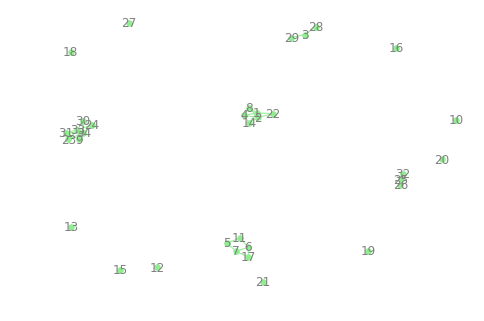

Community Labelling is: {1: 1, 2: 1, 4: 1, 8: 1, 14: 1, 22: 1, 3: 2, 28: 2, 29: 2, 5: 3, 6: 3, 7: 3, 11: 3, 17: 3, 9: 4, 23: 4, 24: 4, 30: 4, 31: 4, 33: 4, 34: 4, 10: 5, 12: 6, 13: 7, 15: 8, 16: 9, 18: 10, 19: 11, 20: 12, 21: 13, 25: 14, 26: 14, 32: 14, 27: 15}
(There are 15 communities now)
Q Modularity is: 0.004109138724523287
Round 43 took 0.9 seconds ( 0.0 mins)

 

ROUND 44 STARTED! 

Iteration 1 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList took 0.0 seconds ( 0.0 mins ).
 Now iteration 1 finished!
Iteration 1 finished. There are 22 / 150 active tuples left. 

Iteration 2 started...
 Now doing Map..
 Now doing Reduce..
 Now collecting Reduce result..
 Now flattening Reduce result..
  Flattening took 0.0 seconds ( 0.0 mins ).
 Now finalising Reduce result by filling in adjList..
  Filling in adjList 

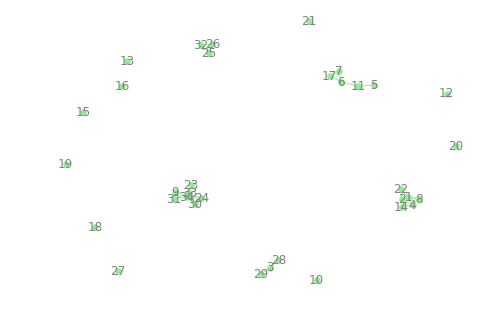

Community Labelling is: {1: 1, 2: 1, 4: 1, 8: 1, 14: 1, 22: 1, 3: 2, 28: 2, 29: 2, 5: 3, 6: 3, 7: 3, 11: 3, 17: 3, 9: 4, 23: 4, 24: 4, 30: 4, 31: 4, 33: 4, 34: 4, 10: 5, 12: 6, 13: 7, 15: 8, 16: 9, 18: 10, 19: 11, 20: 12, 21: 13, 25: 14, 26: 14, 32: 14, 27: 15}
(There are 15 communities now)
Q Modularity is: -0.005588428665351752
Round 44 took 1.3 seconds ( 0.0 mins)

 

Since the Q modularity reached less than 0, we ended the calcuations.
All the  44 rounds finished

Total execution time was 147.2 seconds ( 2.5 mins)

Removed edges were [[((1, 32), 71.39285714285737)], [((1, 3), 66.89517704517712)], [((1, 9), 77.31739926739928)], [((14, 34), 82.00290591761181)], [((20, 34), 123.23291708291718)], [((3, 33), 100.20555555555528)], [((2, 31), 143.62698412698407)], [((2, 3), 109.24999999999969)], [((3, 4), 107.66666666666704)], [((3, 14), 142.7499999999999)], [((3, 8), 285.00000000000074)], [((10, 34), 16.83333333333333)], [((28, 34), 18.183333333333334)], [((3, 10), 17.999999999999996)], 

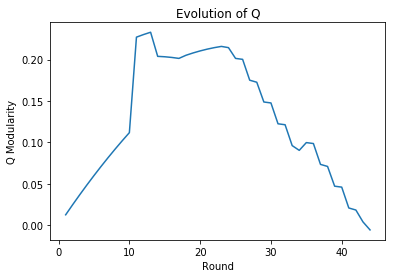

Q list is: [0.012656147271531859, 0.024983563445101886, 0.03698224852071008, 0.048652202498356334, 0.059993425378040754, 0.07100591715976323, 0.08168967784352399, 0.0920447074293228, 0.10207100591715978, 0.11176857330703482, 0.22698882314266933, 0.23011176857330695, 0.23290598290598286, 0.20381328073635752, 0.20332018408941477, 0.2024983563445102, 0.20134779750164367, 0.20512820512820495, 0.20792241946088097, 0.21038790269559493, 0.21252465483234706, 0.21433267587113725, 0.21581196581196588, 0.21433267587113736, 0.20134779750164367, 0.2001972386587772, 0.17504930966469429, 0.1725838264299802, 0.1487508218277449, 0.1476002629848785, 0.12245233399079553, 0.121301775147929, 0.09615384615384615, 0.09040105193951353, 0.09976988823142674, 0.09861932938856033, 0.07347140039447747, 0.07100591715976345, 0.04717291255752798, 0.046022353714661346, 0.0208744247205786, 0.018408941485864694, 0.004109138724523287, -0.005588428665351752]

 Maximum Q was achieved at round 13 and the value was 0.2038132

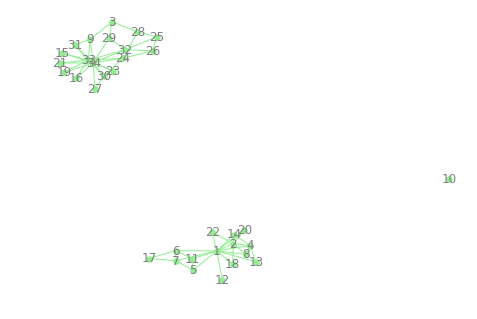

 It took 101.8 seconds ( 1.7 mins) until the network reaches the best community structure.


In [48]:
#Iteration of Stage1-4
import matplotlib.pyplot as plt
import time

#rounds=25
Qlist = []
r=1
removed_edges=[]
print("Data contains", len(nodeId), "nodes, and", nrow, "edges (including duplicates) \n")
t_initial = time.time()
Q = 0
best_achieved = False

#for round_counter in range(rounds):
while Q >= 0:
    print("ROUND", r, "STARTED! \n")
    
# Stage1
    t_start = time.time() 
    # Iteration until status becomes 'i' for all tuples
    act_counter = 1
    ite = 1
    while act_counter > 0:
        print("Iteration", ite, "started...")
        rdd = sc.parallelize(output)
    # <stage1 map>
        print(" Now doing Map..")
        pos_map1 = rdd.flatMap(stage1_map)
    #    test_only = pos_map1.collect()
    #    print("After Map of iteration", ite, ":")
    #    for i in range(len(test_only)):
    #        print(test_only[i])
    # <stage1 reduce>
        print(" Now doing Reduce..")
        red1_twokeys = pos_map1.map(lambda x: ((x[0],x[1][0]), x[1][1:]))
        red1_grouped = red1_twokeys.reduceByKey(join)
        red1_weighted = red1_grouped.map(stage1_reduce)
        print(" Now collecting Reduce result..")
        t1 = time.time()
        record = red1_weighted.map(twokeys_to_onekey).collect()
        t2 = time.time()
        print("  Collecting Reduce result took", round(t2-t1, 1), "seconds (", round((t2-t1)/60, 1), "mins ).")
        print(" Now flattening Reduce result..")
        t3 = time.time()
        
        # 'for' loop to flatten the grouped values (non-parallelized)
        new = []
        for i in range(len(record)):
            if type(record[i][1][1]) is list:
                record[i]
                key = record[i][0]
                srcId = [record[i][1][0]]
                others = record[i][1][1:]
                for j in range(len(others)):
                    s = srcId.copy()
                    o = others[j]
                    s.extend(o)
                    newrec = (key, s)
                    new.append(newrec)
        pos_red1 = list(filter(lambda item: type(item[1][1]) != list, record))  # Save records with only one value
        pos_red1.extend(new)  # Add records which had multiple values
        output = pos_red1.copy()
        t4 = time.time()
        print("  Flattening took", round(t4-t3, 1), "seconds (", round((t4-t3)/60, 1), "mins ).")
        print(" Now finalising Reduce result by filling in adjList..")
        # Fill in adjList before going to next iteration
        t5 = time.time()    
        for i in range(len(output)):
            if output[i][1][5] == []:
                for j in range(len(adj_list)):
                    if adj_list[j][0] == output[i][0]:
                        output[i][1][5] = adj_list[j][1:len(adj_list[j])]
                        break
        t6 = time.time()
        print("  Filling in adjList took", round(t6-t5, 1), "seconds (", round((t6-t5)/60, 1), "mins ).")
        print(" Now iteration",ite ,"finished!")
        act_counter = 0
        for i in range(len(output)):
            if output[i][1][2] == 'a':
                act_counter += 1
        print("Iteration", ite, "finished. There are", act_counter, "/", len(output), "active tuples left. \n")
        ite += 1
    stage1_output = output.copy()
    print("All the Stage1 iterations have finished. Stage1 was iterated for", ite-1, "times.")
    #print("Stage1 result is:")  # DELETE AFTER DEBUGGING
    #for i in range(len(stage1_output)):  # DELETE AFTER DEBUGGING
    #    print(stage1_output[i])  # DELETE AFTER DEBUGGING
    t_end = time.time()
    elapsed_time = t_end-t_start
    elapsed_time_min = elapsed_time/60
    print("Stage1 execution time was", round(elapsed_time, 1), "seconds (", round(elapsed_time_min, 1), "mins ).")

# Stage2
    pre_map2 = sc.parallelize(stage1_output)
    # Apply Map after filtering out tuples which has single node info and duplicated tuples (as we consider undirected graph network)
    pos_map2 = pre_map2.filter(lambda x: x[0] > x[1][0]).flatMap(stage2_map)
    #pos_map2.collect()
    # Stage2 Reduce
    pos_red2_directed = pos_map2.reduceByKey(add)
    # We should ignore the order of node ID at each edge and run reduceByKey(add) again
    pos_red2 = pos_red2_directed.map(lambda x: ((x[0][1], x[0][0]), x[1]) if x[0][0] > x[0][1] else x).reduceByKey(add)
    #pos_red2.collect()
    
# Stage3
    k_iter = 1  # We set k_iter = 1
    # Stage3 Map & Reduce
    distributed_cache = pos_red2.map(lambda x: (x[1], x[0])).sortByKey(False).map(lambda x: (x[1], x[0])).take(k_iter)
    top5 = pos_red2.map(lambda x: (x[1], x[0])).sortByKey(False).map(lambda x: (x[1], x[0])).take(5)
    print("Edge betweenness Score Top 5 is:", top5)   
    print("Round", r, "removes", distributed_cache)
    removed_edges.append(distributed_cache)
    
# Stage4
    pos_map4 = pre_map2.flatMap(stage4_map)
    #print("post map4 result is:")  # DELETE AFTER DEBUGGING
    #for i in range(len(debug)):  # DELETE AFTER DEBUGGING
    #    print(debug[i])  # DELETE AFTER DEBUGGING
    pos_red4 = pos_map4.reduceByKey(stage4_reduce).flatMap(revision)
    output = pos_red4.collect()
    #print("Stage4 output is:")  # DELETE AFTER DEBUGGING
    #for i in range(len(output)):  # DELETE AFTER DEBUGGING
    #    print(output[i])  # DELETE AFTER DEBUGGING
    elist = from_tuples_to_edgelist(output)
    print("After the edge removal, the graph is:")
    draw_graph(elist, r)
# Update adj_list 
    adj_list = []
    for i in range(len(output)):
        targ = [output[i][0]]
        targ.extend(output[i][1][5])
        adj_list.append(targ)
    adj_list = set(map(tuple, adj_list))  # Remove duplicates
    adj_list = list(adj_list)
    adj_list = list(map(list, adj_list))
    #print("New adj_list is:", adj_list)  # DELETE AFTER DEBUGGING
    Q_fun_result = Q_modularity(elist, nodes)
    Q = Q_fun_result[0]
    community = Q_fun_result[1]
    print("Community Labelling is:", community)
    print('(There are', len(set(community.values())), 'communities now)')
    print("Q Modularity is:", Q)
    Qlist.append(Q)
    if (r > 1) and (Qlist[r-1]-Qlist[r-2] < 0) and (best_achieved != True):
        best_achieved = True
        r_best = r-1
        elist_best = elist
        Q_best = Q
        community_best = community
        t_best = time.time()
    t_r_end = time.time() 
    r_time = t_r_end - t_start
    print('Round', r, 'took', round(r_time, 1), 'seconds (', round(r_time/60, 1), 'mins)')
    r += 1
    print("\n \n")
t_terminal = time.time()
total_time = t_terminal - t_initial
print('Since the Q modularity reached less than 0, we ended the calcuations.')
print('All the ', r-1, 'rounds finished')
print('\nTotal execution time was', round(total_time, 1), 'seconds (', round(total_time/60, 1), 'mins)\n')
print('Removed edges were', removed_edges)
print('Please check the saved figures under "./Data/Figures"')
x_axis = [x+1 for x in range(r-1)]
plt.plot(x_axis, Qlist)
plt.title("Evolution of Q")
plt.xlabel("Round")
plt.ylabel("Q Modularity")
plt.show()
print('Q list is:', Qlist)
print('\n Maximum Q was achieved at round', r_best, 'and the value was', Q_best) #np.argmax(Qlist)+1
print(' The best community structure is:', community_best)
print('  and there are', len(set(community_best.values())), 'communities.')
print(' The graph at the best was:')
draw_graph(elist_best, r_best)
print(' It took', round(t_best-t_initial, 1), 'seconds (', round((t_best-t_initial)/60, 1), 'mins) until the network reaches the best community structure.')


## 7. Result and discussion

1) Try with different datasets with different size  
2) Scale out (increase the number of computing instances)  
3) In which case we better use Spark?

## 8. Efficiency

1) Measure the strength of comunities (?)  
2) Try k_itr = 10 and compare executing time  
3) We can compare above result with that of non-parallelized algorithm (only if we have time)

## 9. References

1) S. Moon, et al., Parallel community detection on large graphs with MapReduce and GraphChi, Data Knowl. Eng. (2015)  
2) M.E. Newman, M. Girvan, Finding and evaluating community structure in networks, Phys. Rev. E 69 (2) (2004) 026113  
3) etc.

## Visualisation Part

1) Great if we can visualise large network as well  
2) There might be better way to draw a graph

These pages could be of our use:
- https://www.kaggle.com/kevinvdsk/community-detection  
- https://stackoverflow.com/questions/43541376/how-to-draw-communities-with-networkx  
- https://www.cl.cam.ac.uk/teaching/1314/L109/tutorial.pdf